# Running Adaboost on the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier as abclf
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.metrics import confusion_matrix
from pcfm import plot_confusion_matrix
from pfimp import plot_feature_importance
from sklearn.model_selection import StratifiedKFold
from threeinone import cfm3in1, fimp3in1
from fpr_area import givemis,areas,erts_plot,thres

In [2]:
df = pd.read_csv('all_in_one.csv')
df = pd.DataFrame.as_matrix(df)
# It seems there are NaNs in the dataset.. 
# And all of them are in column 3. The one with log(.)
df = df[~np.isnan(df).any(axis=1)]
X = df[:,0:6] # Our feature matrix
y = np.array(df[:,-1],dtype=np.int) # Our truth labels
idx = np.array(df[:,6],dtype=np.int) # our ID
clname = ['RFI','PULSAR']
np.set_printoptions(precision=2)

## No oversampling

In [3]:
kf = StratifiedKFold(3,shuffle=True,random_state=340)
conf_mats = [] # list to hold the confusion matrices
fimpl = [] # list to hold the feature importances
predprobs = [] # predicted probabilities

In [4]:
# Hyperparameters
num_trees = 500
random_seed = 9876
num_obj_leaf_node = 6

In [28]:
rc = 0
plt.figure()
conf_mats = [] # list to hold the confusion matrices
for tr,te in kf.split(X,y):
     print "[",rc,'] Iteration...Starting'
     xtrain, xtest = X[tr],X[te]
     ytrain, ytest,ytid = y[tr],y[te],idx[te]
     dclf = dtc(random_state=random_seed,max_depth=6)
     adclf = abclf(base_estimator=dclf,n_estimators=500,random_state=1234)
     print "[``] Fitting"
     adclf.fit(xtrain,ytrain) # My fitting
     ypredict = adclf.predict(xtest)
     conf_mats.append(confusion_matrix(ytest,ypredict))
     imp = adclf.feature_importances_
     fimpl.append(imp)
     ypp = adclf.predict_proba(xtest)
     tdf = np.column_stack((ytest,ypredict,ypp[:,0],ypp[:,1]))
     if rc == 0:
        outdf = tdf
     else:
        outdf = np.concatenate((outdf,tdf),axis=0)
     print "[",rc,'] Iteration...Done'
     rc = rc + 1

[ 0 ] Iteration...Starting
[``] Fitting
[ 0 ] Iteration...Done
[ 1 ] Iteration...Starting
[``] Fitting
[ 1 ] Iteration...Done
[ 2 ] Iteration...Starting
[``] Fitting
[ 2 ] Iteration...Done


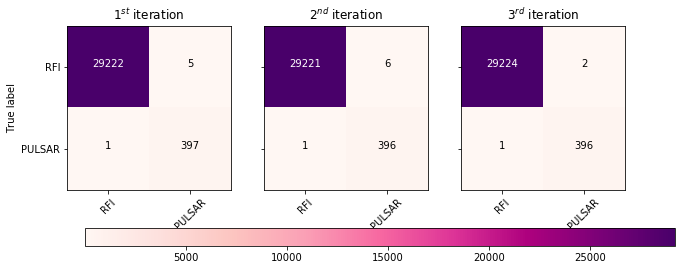

In [29]:
cfm3in1(conf_mats,clname)
plt.show()

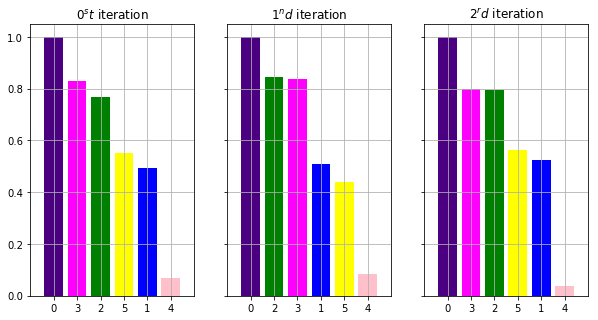

In [7]:
fimp3in1(fimpl)
plt.show()

## SMOTE
SMOTE is a way to learn imbalanced or highly skewed datasets. 
We specify a ratio of minority samples(pulsars) and majority samples(RFIs) and SMOTE using K-means and interpolation, generates new samples of the minority class until the desired ratio is achieved. 

After getting sX,sy afterever follows is the same. Fitting and plotting just with a minor change that I've prepended 'sm' to each variable to differentiate.

In [21]:
from imblearn.over_sampling import SMOTE
# this is one additional function I'll be needing
sme = SMOTE(ratio=0.5,random_state=1234) # please refer the above section for param definitions.
smX,smy = sme.fit_sample(X,y) # transforming 

In [22]:
smkf = StratifiedKFold(3,shuffle=True,random_state=340)
smconf_mats = [] # list to hold the confusion matrices
smfimpl = [] # list to hold the feature importances
smpredprobs = [] # predicted probabilities

In [23]:
rc = 0
plt.figure()
for tr,te in kf.split(smX,smy):
     print "[",rc,'] Iteration...Starting'
     xtrain, xtest = smX[tr],smX[te]
     ytrain, ytest= smy[tr],smy[te]
     smdclf = dtc(max_leaf_nodes=num_obj_leaf_node,random_state=random_seed)
     smadclf = abclf(base_estimator=smdclf,n_estimators=num_trees,random_state=1234)
     print "[``] Fitting"
     smadclf.fit(xtrain,ytrain) # My fitting
     ypredict = smadclf.predict(xtest)
     smconf_mats.append(confusion_matrix(ytest,ypredict))
     imp = smadclf.feature_importances_
     smfimpl.append(imp)
     ypp = smadclf.predict_proba(xtest)
     tdf = np.column_stack((ytest,ypredict,ypp[:,0],ypp[:,1]))
     if rc == 0:
        smoutdf = tdf
     else:
        smoutdf = np.concatenate((smoutdf,tdf),axis=0)
     print "[",rc,'] Iteration...Done'
     rc = rc + 1

[ 0 ] Iteration...Starting
[``] Fitting
[ 0 ] Iteration...Done
[ 1 ] Iteration...Starting
[``] Fitting
[ 1 ] Iteration...Done
[ 2 ] Iteration...Starting
[``] Fitting
[ 2 ] Iteration...Done


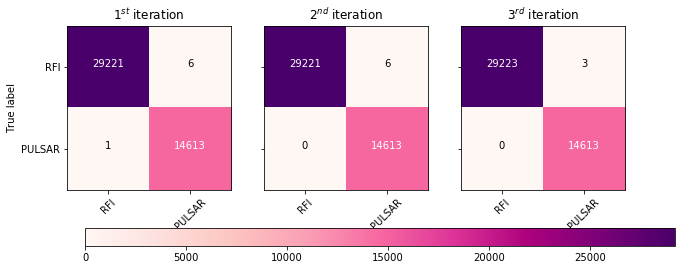

In [24]:
cfm3in1(smconf_mats,clname)
plt.show()

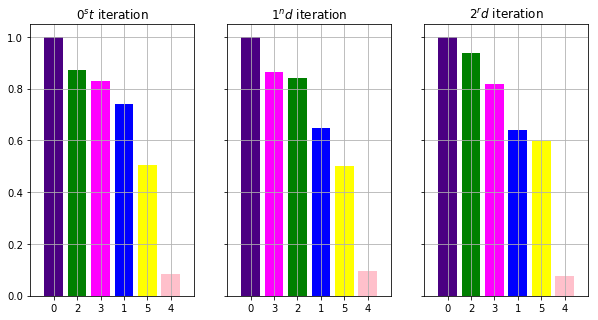

In [25]:
fimp3in1(smfimpl)
plt.show()

## FPR Analysis

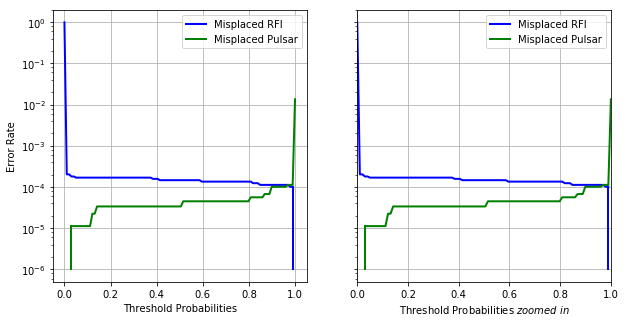

In [13]:
erts_plot(givemis(outdf,0.0,1.0),givemis(outdf,0.0,1.0),[0.0,1.0])
plt.show()

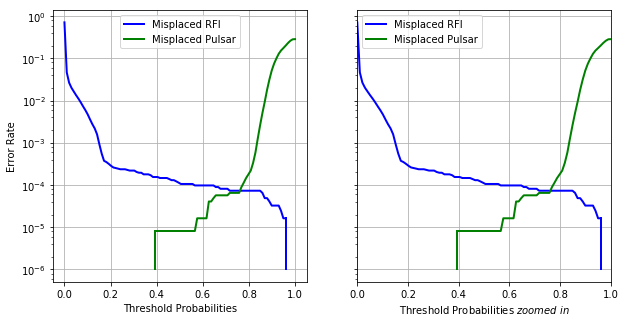

In [14]:
erts_plot(givemis(smoutdf,0.0,1.0),givemis(smoutdf,0.3,1.0),[0.3,1.0])
plt.show()

In [40]:
thres(0.1,outdf)

FPR: 0.000168782068593
FNR: 1.12521379062e-05
Recall: 0.999161073826
Precision: 0.987562189055


In [41]:
thres(0.9,outdf)

FPR: 0.000112521379062
FNR: 0.000101269241156
Recall: 0.99244966443
Precision: 0.991617770327


In [42]:
thres(0.8,outdf)

FPR: 0.000135025654874
FNR: 4.50085516248e-05
Recall: 0.996644295302
Precision: 0.99


In [45]:
thres(0.5,smoutdf)

FPR: 0.000114051094891
FNR: 7.60340632603e-06
Recall: 0.999977189781
Precision: 0.999657955945


In [44]:
thres(0.7,smoutdf)

FPR: 8.36374695864e-05
FNR: 3.04136253041e-05
Recall: 0.999908759124
Precision: 0.999749127648


In [43]:
thres(0.9,smoutdf)

FPR: 3.80170316302e-05
FNR: 0.0441149635036
Recall: 0.867655109489
Precision: 0.999868569776


## Metric scores

In [30]:
from sklearn.metrics import *

In [34]:
print "The recall score is    {:0.4f}".format(recall_score(outdf[:,0],outdf[:,1]))
print "The precision score is {:0.4f}".format(precision_score(outdf[:,0],outdf[:,1]))
print "The accuracy is        {:0.4f}".format(accuracy_score(outdf[:,0],outdf[:,1]))
print "The f1 score is        {:0.4f}".format(f1_score(outdf[:,0],outdf[:,1]))
print "The logloss score is   {:0.4f}".format(log_loss(outdf[:,0],outdf[:,1]))
print "The MCC is             {:0.4f}".format(matthews_corrcoef(outdf[:,0],outdf[:,1]))

The recall score is    0.9975
The precision score is 0.9892
The accuracy is        0.9998
The f1 score is        0.9933
The logloss score is   0.0062
The MCC is             0.9932


In [37]:
print "The recall score is    {:f}".format(recall_score(smoutdf[:,0],smoutdf[:,1]))
print "The precision score is {:0.4f}".format(precision_score(smoutdf[:,0],smoutdf[:,1]))
print "The accuracy is        {:0.4f}".format(accuracy_score(smoutdf[:,0],smoutdf[:,1]))
print "The f1 score is        {:0.4f}".format(f1_score(smoutdf[:,0],smoutdf[:,1]))
print "The logloss score is   {:0.4f}".format(log_loss(smoutdf[:,0],smoutdf[:,1]))
print "The MCC is             {:0.4f}".format(matthews_corrcoef(smoutdf[:,0],smoutdf[:,1]))

The recall score is    0.999977
The precision score is 0.9997
The accuracy is        0.9999
The f1 score is        0.9998
The logloss score is   0.0042
The MCC is             0.9997


## Area analysis

In [38]:
areas(givemis(outdf,0.0,1.0))

mmint 4.31616097968e-05
mis1 0.0042984966386
mis2 9.98485166727e-05


In [39]:
areas(givemis(smoutdf,0.0,1.0))

mmint 1.78180835115e-05
mis1 0.00470906858529
mis2 0.0211855540912
